# 2018 10 26 Gabors with moving average as a replacement for ST filters
On importe vidéo et bibs ainsi que le filtre temporal à deux gaussienne

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

video = np.load('../montypython.npy')
video = np.rot90(video)

video = np.append(video, video, axis = 2)

In [2]:
video.shape

(54, 54, 4096)

In [3]:
def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain

# Définir le moving average 
Avec cumsum sur la période initframe à initframe+framesize, puis avec un moyennage, ça tourne très très vite

In [4]:
framesize = 15 #size of the moving average window
initframe = 1 #initialization step

total_avg = []
for windows in range(video[:,:,:-1].shape[-1]) :
    initframe +=1
    avg = np.cumsum(video[:,:,initframe:initframe+framesize], axis = 0)
    avg = np.mean(avg)
    total_avg.append(avg)

/home/hugo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hugo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Convoluer avec la réponse temporelle de Cai

In [5]:
tempo_cai = [temporal_filter(i, gain = -1) for i in np.linspace(0,len(total_avg), len(total_avg))]
convolved = np.convolve(total_avg, tempo_cai)

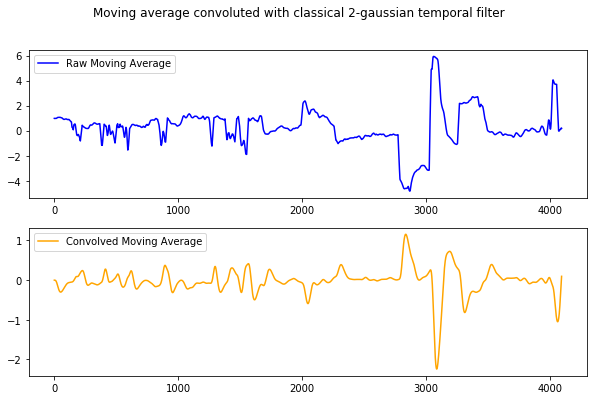

In [6]:
fig, axs = plt.subplots(2,1, figsize = (10,6))

axs[0].plot(total_avg, label = 'Raw Moving Average', color = 'b')
axs[0].legend(loc = 2)

axs[1].plot(convolved, label = 'Convolved Moving Average', color = 'orange')
axs[1].legend(loc = 2)

plt.suptitle('Moving average convoluted with classical 2-gaussian temporal filter')
plt.savefig('./figs/2018_10_26_MA+temporal.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

plt.show()

# Maintenant on crée le Gabor
Sur un petit subset de l'image de 8x8, qui est la taille des champs récepteurs ST classique, comme ça on compare ce qui est comparable

In [7]:
parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
 'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
 'do_whitening': True, 'dpi': 450,'edgefigpath': 'results/edges','edgematpath': 'cache_dir/edges',
 'ext': '.pdf','figpath': 'results','figsize': 14.0,'formats': ['pdf', 'png', 'jpg'],
 'mask_exponent': 3.0, 'matpath': 'cache_dir','n_theta': 24, 'noise': 0.1, 'seed': None,
 'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
 'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
 'white_recompute': False, 'white_steepness': 4.0}

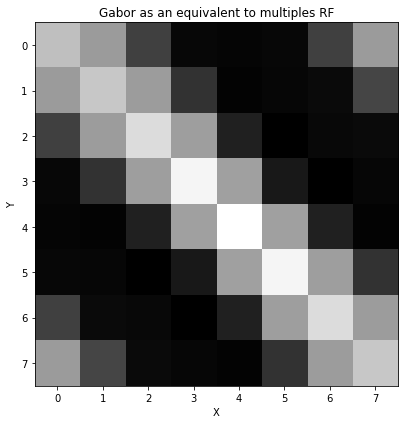

In [8]:
from LogGabor import LogGabor
N_X, N_Y, N_frame = video.shape
N_X = int(N_X/7)+1
N_Y = int(N_Y/7)+1

lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))

B_theta = 10 /180 * np.pi
params= {'sf_0':.05, 'B_sf': 1.5, 'B_theta': B_theta}

N_phase = 2
theta = 3*np.pi/4
phi = np.zeros((1, N_phase, N_X, N_Y))

x = N_X/2 #gabor centered
y = N_Y/2
params.update(theta=theta)
for i_phase in range(N_phase):
    phase = i_phase * np.pi/2
    kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
    phi[0, i_phase, :] = lg.normalize(kernel)

fig, ax = plt.subplots(figsize = (6,6))
ax.imshow(phi[0, 0,], cmap=plt.gray()) #[theta_nbr, phase, content]
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gabor as an equivalent to multiples RF')
plt.tight_layout()

# La partie avec l'arobase magique

In [9]:
gabor_video = np.asarray(video[23:31, 23:31])
gabor_video = gabor_video.reshape((8*8, video.shape[-1]))
print('gabor_video.shape', gabor_video.shape)

gabor_video.shape (64, 4096)


In [10]:
phi_ = phi.reshape((1, 2, 8*8))
print('phi_.shape', phi_.shape)

phi_.shape (1, 2, 64)


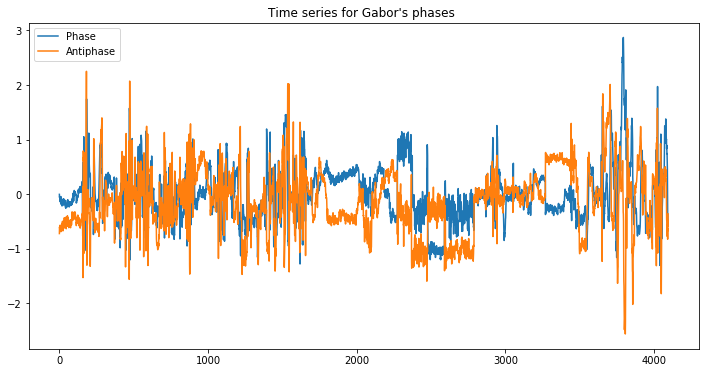

In [11]:
code = phi_ @ gabor_video
plt.figure(figsize = (12,6))
plt.plot(code[0][0], label = 'Phase')
plt.plot(code[0][1], label = 'Antiphase')
plt.title("Time series for Gabor's phases ")
plt.legend()
plt.show()

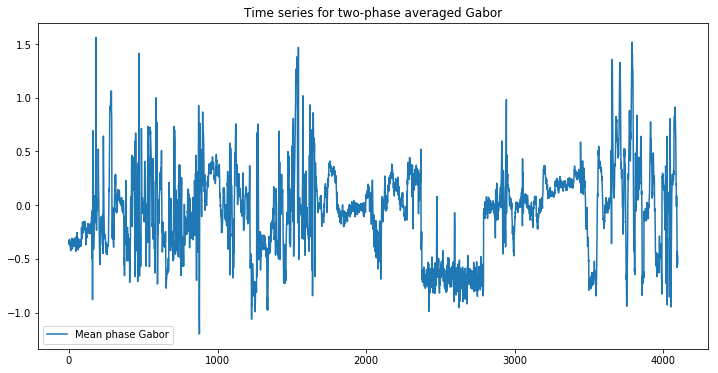

In [12]:
mean_gabor_output = np.mean(code[0], axis = 0)
plt.figure(figsize = (12,6))
plt.plot(mean_gabor_output, label = 'Mean phase Gabor')
plt.legend()
plt.title('Time series for two-phase averaged Gabor')
plt.show()

# Convolution de la composante spatiale (Gabor) et temporelle (MA+Gaussienne)

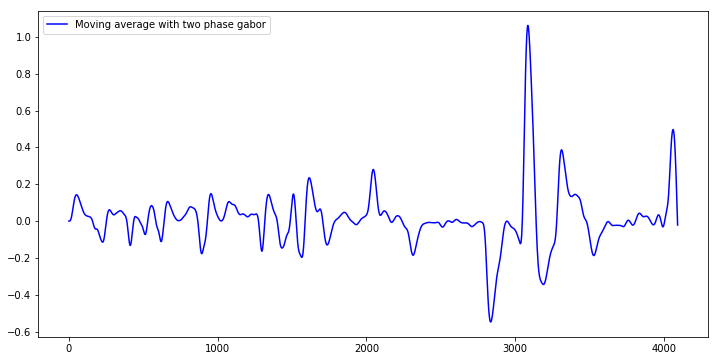

In [13]:
maga = mean_gabor_output[-1] * convolved[::2]#Moving Average Gabor Average

plt.figure(figsize = (12,6))
plt.plot(maga, label = 'Moving average with two phase gabor', color = 'b')

'''plt.plot(code[0][1][-1] * convolved[::2], label = 'Moving average with gabor antiphase', color = 'r',
        linestyle = '-.', alpha = .5)
plt.plot(code[0][0][-1] * convolved[::2], label = 'Moving average with gabor phase', color = 'b',
        linestyle = '--', alpha = .8)'''

#erreur de xlabel sur le plot quand on fait la multiplication en début de cellule... bizarre
plot_times = np.array([0, 500, 1000, 1500, 2000])
plt.xticks(plot_times, plot_times*2)

plt.legend()
plt.show()

# V1 membrane potential driver

In [14]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

total_time = 4000
mean_gabor_input = np.mean(code[0], axis = 0) #mean of phase and antiphase activations

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [15]:
def VanillaRasterPlot( SpikesP, SpikesE, spike_thresh,injections, title = 'Title', markersize = .5, 
                         figsize = (9,6), shifts = None):
    
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
        
        fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = figsize)
        
        color=iter(plt.cm.gist_heat(np.linspace(.5,.8, 20)))
        for traces in injections:
            axs[0].plot(traces.get_data(), color = next(color))
        axs[0].set_ylabel('I (nA)')
        axs[0].set_title('Input')
        axs[0].set_xticklabels([])
        
        axs[1].plot(SpikesE.analogsignals[0].times, SpikesE.analogsignals[0])
        axs[1].set_ylabel('Voltage')
        axs[1].set_title('V1 neuron with alpha-function dynamics ')
        
        plt.xlabel('Time (ms)')
        
        return fig, axs  

Simulation done in 0.98 s


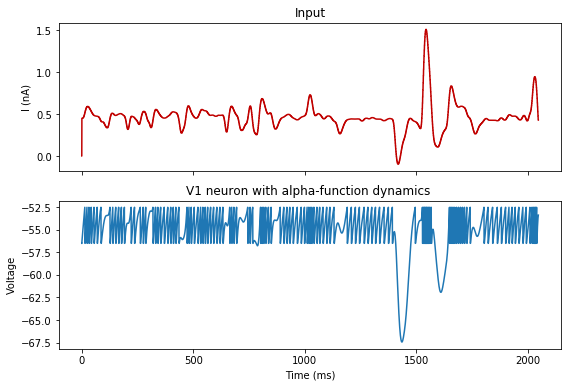

In [16]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,total_time)
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


current_levels = maga[::injection_sampling_rate]+.45
current_input = sim.StepCurrentSource(times = current_times,
                                 amplitudes = current_levels)
current_input.inject_into(post)
current_list.append(current_input)
current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v2 = post.get_data().segments[0]
sig = post_v2.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v2, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
#fig.savefig('./figs/2018_10_24_GABOR_to_V1_.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

# Maintenant on compare avec les résultats des ST

In [17]:
def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X,Y = np.meshgrid(x,y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z

def temporal_filter(t = 1 , response_time = 175, refrac_time = 50,
                   K1 = .92, c1 = 0.2, n1 = 7, t1 = -6,
                   K2 = .2, c2 = .12, n2 = 8, t2 = -6,
                   baseline = 0., gain = 90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''
    
    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ( (c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / (n1**2)*np.exp(-n1)
    p -= K2 * ( (c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / (n2**2)*np.exp(-n2)
    return p*gain #oups je me suis planté d'un facteur 90, c'est un sacré miss



############
# Constants
############
total_time = video.shape[-1] #ms,
fps = 24 #c'est pas très gamer tout ça 
filter_size = 2.
filter_res = .1

coo_min = len(video[:,:,0])/2 - 5
coo_max = len(video[:,:,0])/2 + 5
grid_res = .5

filters_coordinates = np.mgrid[coo_min:coo_max:grid_res].reshape(2,-1).T

print('Filter array size', filters_coordinates.shape)

Filter array size (10, 2)


In [18]:
frame_duration = int(total_time/fps)

stimuli = []
for ms in range(int(total_time/frame_duration)) :
    for same_frame in range(frame_duration):
        stimuli.append(video[:,:,ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])

In [19]:
stimuli = video

In [20]:
###########
# Multiple filters 
###########

convo_list = []
st_list = [] # a list of spatiotemporal filters for tests with plotting
Xs = []
Ys = []

for filt in tqdm(range(len(filters_coordinates)), 'Making filters') :
    X,Y,Z = spatial_filter(wx = filter_size, wy=filter_size,
                           xres = filter_res, yres = filter_res,
                           x_trans= filters_coordinates[filt][0],
                          y_trans = filters_coordinates[filt][1]) 
    t = [temporal_filter(i) for i in np.linspace(0,total_time, total_time)]
    
    #Convolution coordinates, centered around the filter and the size of the filter space
    X_convo_minus = int(filters_coordinates[filt][0]-filter_size)
    X_convo_plus = int(filters_coordinates[filt][0]+filter_size)
    Y_convo_minus = int(filters_coordinates[filt][1]-filter_size)
    Y_convo_plus = int(filters_coordinates[filt][1]+filter_size)
    
    activations = []
    for i in np.linspace(0, total_time-1, total_time):
        activations.append(np.max(stimuli[:,:,int(i)][X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus] \
                                  *Z[X_convo_minus:X_convo_plus,Y_convo_minus:Y_convo_plus]))
    
    ys = np.convolve(t, activations)
    st = Z[:, :, None] * ys[None, None, :]
    
    convo_list.append(ys)
    st_list.append(st)
    
    Xs.append(X)
    Ys.append(Y)


st_levels = []
for ft in range(len(st_list)):

    st_level = []
    for i in range(video.shape[-1]):
        st_level.append(np.max(st_list[ft][:,:,i]))
    st_levels.append(st_level)

Making filters: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s]


Simulation done in 2.29 s


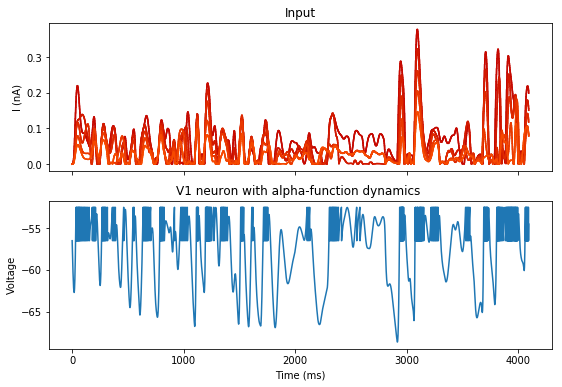

In [21]:
##########
# Params #
##########
import time
now = time.time()
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick
                    }

injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][::injection_sampling_rate]))
current_list = []
##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")



for inputs in range(len(st_levels)):
    '''current_times = np.linspace(0, len(st_levels[inputs][::injection_sampling_rate]),
                                len(st_levels[inputs][::injection_sampling_rate]))
    '''
    current_levels = st_levels[inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)
    current_levels /=1.7
    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()

post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]


markersize = 3
fig, axs = VanillaRasterPlot(SpikesP = None, SpikesE = post_v, injections = current_list,
                 spike_thresh = neuron_params['v_thresh'], markersize = 3)

then = time.time()
print('Simulation done in %.2f s' % (then-now))
fig.savefig('./figs/2018_10_24_Filters_to_V1_angular.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')

Text(0.5,0.98,'Mouais mouais mouais...')

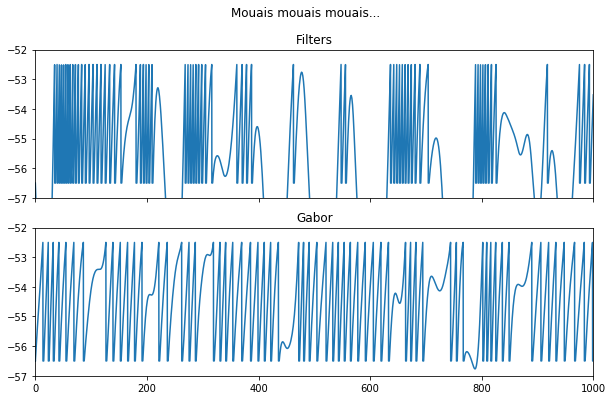

In [22]:
fig, axs = plt.subplots(2,1, figsize = (10,6))
axs[0].plot(post_v.analogsignals[0].times, post_v.analogsignals[0])
axs[0].set_ylim(-57,-52)
axs[0].set_xlim(0,1000)
axs[0].set_title('Filters')
axs[0].set_xticklabels([])


axs[1].plot(post_v2.analogsignals[0].times, post_v2.analogsignals[0])
axs[1].set_title('Gabor')
axs[1].set_ylim(-57,-52)
axs[1].set_xlim(0,1000)

plt.suptitle ('Mouais mouais mouais...')